In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
import pandas as pd
from functools import partial
import yaml
%config Completer.use_jedi = False

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/OK/OK_resentencing/OK_prison_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_baseline(['prison', 'release'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 240 results
transitions_data returned 40 results
total_population_data returned 0 results


initialization time:  5.142341136932373
initialization time:  5.098176002502441
simulation_time:  6.206619739532471
simulation_time:  6.450852870941162


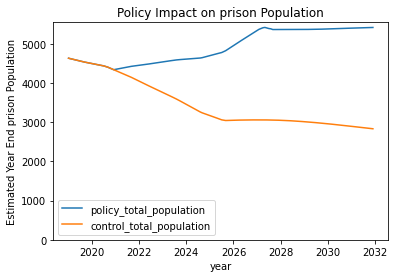

In [4]:
pd.set_option('display.max_rows', 500)

# Policy Option Methods
policy_transitions = pd.DataFrame({
    'compartment': ['prison'] * 7,
    'outflow_to': ['release'] * 7,
    'compartment_duration': [2222.00 / 365 * 12, 2291.20 / 365 * 12, 2330.40 / 365 * 12, 2320.10/ 365 * 12, 2484.80/ 365 * 12,
                             2412.00/ 365 * 12, 2382.40 / 365 * 12],
    'total_population': [1] * 7,
    'crime_type': ['NA'] * 7
})
policy_outflows = test_sim.initializer.data_dict['outflows_data'][(test_sim.initializer.data_dict['outflows_data'].compartment == 'pretrial')
                                                                  & (test_sim.initializer.data_dict['outflows_data'].time_step < 96)]

def resentencing_transitions(retroactive=False):
    return partial(CompartmentTransitions.use_alternate_transitions_data, 
                   alternate_historical_transitions=policy_transitions,
                   retroactive=retroactive)

def resentencing_outflows():
    return partial(ShellCompartment.use_alternate_outflows_data,
                  alternate_outflows_data=policy_outflows)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=resentencing_transitions(),
                spark_compartment='prison',
                sub_population={'crime_type': 'NA'},
                apply_retroactive=False),
    SparkPolicy(policy_fn=resentencing_outflows(),
                spark_compartment='pretrial',
                sub_population={'crime_type': 'NA'},
                apply_retroactive=False),
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [5]:
simulation_tag = 'OK_resentencing'
test_sim.upload_simulation_results_to_bq(simulation_tag)

In [9]:
policy_transitions.index = policy_transitions.crime_type
policy_transitions

,compartment,outflow_to,compartment_duration,total_population,crime_type
0,prison,release,73.052055,1,NA
1,prison,release,75.327123,1,NA
2,prison,release,76.615890,1,NA
3,prison,release,76.277260,1,NA
4,prison,release,81.692055,1,NA
5,prison,release,79.298630,1,NA
6,prison,release,78.325479,1,NA


In [8]:
test_sim.pop_simulations['control'].sub_simulations['x'].simulation_compartments['prison_parole_revocations'].transition_tables.transition_dfs

{'before':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'transitory':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'after_retroactive':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.

In [4]:
test_data = pd.DataFrame({
            'compartment_duration': [1, 2, 5],
            'total_population': [2, 4, 1],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
new_data = pd.DataFrame({
            'compartment_duration': [1, 2, 3],
            'total_population': [1, 2, 4],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
def policy():
    return partial(CompartmentTransitions.use_alternate_transitions_data, alternate_historical_transitions=new_data, retroactive=True)
t = CompartmentTransitions(test_data)
t.initialize([SparkPolicy(policy_fn=policy(),
                spark_compartment='prison',
                sub_population={'crime_type': 'x'},
                apply_retroactive=True)])


In [5]:
t.transition_dfs

{'before': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.285714   0.714286
 2                     0.800000   0.200000
 3                     0.000000   1.000000
 4                     0.000000   1.000000
 5                     1.000000   0.000000,
 'transitory': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.142857   0.857143
 2                     0.200000   0.800000
 3                     1.000000   0.000000
 4                     1.000000   0.000000
 5                     1.000000   0.000000,
 'after_retroactive': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.142857   0.857143
 2                     0.333333   0.666667
 3                     1.000000   0.000000
 4                     1.000000   0.000000
 5                     1.000000   0.000000,
 'after_non_retroactive': outflow_to             

In [ ]:
test_sim.data_dict['transitions_data']